In [49]:
import tempfile

from monai.utils import first, set_determinism
from monai.transforms import(
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    BorderPadd,
    Spacingd,
    RandAdjustContrastd,
    RandRotate90d,
    ToTensord,
    ScaleIntensityd,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


In [2]:
directory = os.environ.get("monai_results")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpdoujzt1b


In [52]:
padding=10
num_sample=10
CropSize = [64,64,64]
train_transforms = Compose(
        [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
        BorderPadd(keys=["image", "label"],spatial_border=padding),
        ScaleIntensityd(
            keys=["image"],minv = 0.0, maxv = 1.0, factor = None
        ),
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=CropSize,
            pos=1,
            neg=1,
            num_samples=num_sample,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        RandAdjustContrastd(
            keys=["image"],
            prob=0.8,
            gamma = (0.5,2)
        ),
        ToTensord(keys=["image", "label"]),
        ]
    )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #     keys=["image", "label"],
        #     pixdim=(1.5, 1.5, 2.0),
        #     mode=("bilinear", "nearest"),
        # ),
        # ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [53]:
data_dir = "data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x7f7c9c530390>

image shape: torch.Size([1, 419, 426, 222]), label shape: torch.Size([1, 419, 426, 222])


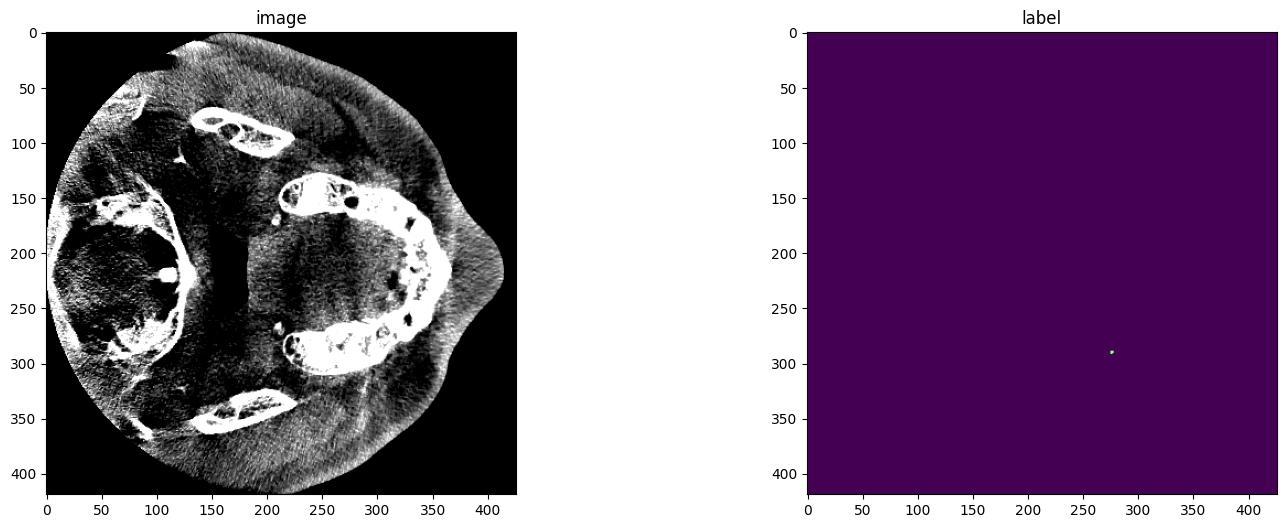

In [40]:
slice_map = {
    "paciente_4.nii.gz": 197,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()